In [1]:
import os, sys
import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import cohen_kappa_score
import category_encoders as ce

from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb

from functools import partial
import scipy as sp              # for optimize.minimize()

In [2]:
# Execution environment setting
Kaggle = True

if Kaggle:
    DIR = '../input/data-science-bowl-2019'
    task_type = 'CPU'
else:
    DIR = './data-science-bowl-2019'
    task_type = 'GPU'

## Observe the data

In [3]:
train = pd.read_csv(os.path.join(DIR,'train.csv'))
train_labels = pd.read_csv(os.path.join(DIR,'train_labels.csv'))
specs = pd.read_csv(os.path.join(DIR,'specs.csv'))
test = pd.read_csv(os.path.join(DIR,'test.csv'))

In [4]:
print('train:\t\t',train.shape)
print('train_labels:\t',train_labels.shape)
print('specs:\t\t',specs.shape)
print('test:\t\t',test.shape)

train:		 (11341042, 11)
train_labels:	 (17690, 7)
specs:		 (386, 3)
test:		 (1156414, 11)


### 1. train

In [5]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [6]:
train[['event_id','game_session','installation_id',
       'title','type','world']].describe()

,event_id,game_session,installation_id,title,type,world
count,11341042,11341042,11341042,11341042,11341042,11341042
unique,384,303319,17000,44,4,4
top,1325467d,6e6e697f2e593de1,f1c21eda,Chow Time,Game,MAGMAPEAK
freq,274673,3368,58988,1150974,5795293,5023687


In [7]:
event_code_n = train['event_code'].nunique()
print("num of unique 'event_code':", event_code_n)
print("'event_code': ",
      train['event_code'].min(), "-", train['event_code'].max())

num of unique 'event_code': 42
'event_code':  2000 - 5010


In [8]:
# 'event_data' exsample
print(train['event_data'][40])
print(train['event_data'][41])
print(train['event_data'][43])

{"coordinates":{"x":608,"y":663,"stage_width":1015,"stage_height":762},"event_count":39,"game_time":24773,"event_code":4070}
{"description":"Drag the shovel to the molds to fill them up!","identifier":"Dot_DragShovel","media_type":"audio","total_duration":2070,"event_count":40,"game_time":25040,"event_code":3010}
{"description":"Drag the shovel to the molds to fill them up!","identifier":"Dot_DragShovel","media_type":"audio","duration":2083,"event_count":42,"game_time":27123,"event_code":3110}


### 2. train_labels

In [9]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [10]:
train_labels[['game_session','installation_id', 'title']].describe()

,game_session,installation_id,title
count,17690,17690,17690
unique,17690,3614,5
top,fb965d2b271605bf,08987c08,Cart Balancer (Assessment)
freq,1,156,4151


In [11]:
# unique 'title' list
train_labels['title'].unique()

array(['Mushroom Sorter (Assessment)', 'Bird Measurer (Assessment)',
       'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)',
       'Cart Balancer (Assessment)'], dtype=object)

### 3. specs

In [12]:
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [13]:
specs.describe()

,event_id,info,args
count,386,386,386
unique,386,168,191
top,47efca07,This event occurs when the player clicks on th...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
freq,1,17,25


In [14]:
# 'info' exsample
print(specs['info'][0],'\n')
print(specs['info'][6],'\n')
print(specs['info'][7])

The end of system-initiated feedback (Correct) event occurs when the game finishes delivering feedback to the player in response to a correct round attempt (pressing the go button with the correct answer). It contains information that describes the duration and content of the instruction, and will likely occur in conjunction with a beat round event. These events are used to determine the effectiveness of the feedback. We can answer questions like, "how much time elapsed while the game was presenting feedback?" 

This event occurs when the player drops a weight from the resource table to someplace other than the pan balance (including back on the table). It contains information about the destination and the state of the game. This event is used to diagnose player strategies and understanding. 

The system-initiated instruction event occurs when the game delivers instructions to the player. It contains information that describes the content of the instruction. This event differs from eve

In [15]:
# 'args' exsample
print(specs['args'][0],'\n')
print(specs['args'][1])

[{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"round","type":"int","info":"number of the current round when the event takes place or 0 if no round"},{"name":"level","type":"int","info":"number of the current level when the event takes place or 0 if no level"},{"name":"description","type":"string","info":"the text or description of the instruction"},{"name":"identifier","type":"string","info":"a unique identifier for this piece of instruction"},{"name":"media_type","type":"string","info":"the type of media that has just played:\n'audio' || 'animation' || 'other'"},{"name":"duration","type":"int","info":"the duration of the media playback in milliseconds"},{"name":"event_count","type":"int","info":"session event counter"},{"name":"event_code","type":"int","info":"event class identifier"}] 

[{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"description","type":"string","info":"the text or description of t

### 4. test

In [16]:
test.head(8)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES
5,f93fc684,a022c3f60ba547e7,2019-09-10T16:54:14.338Z,"{""coordinates"":{""x"":515,""y"":697,""stage_width"":...",00abaee7,2,4010,2232,Chow Time,Game,CRYSTALCAVES
6,7ec0c298,a022c3f60ba547e7,2019-09-10T16:54:16.553Z,"{""description"":""It's Chow Time! We have some V...",00abaee7,3,3010,4445,Chow Time,Game,CRYSTALCAVES
7,0d1da71f,a022c3f60ba547e7,2019-09-10T16:54:23.364Z,"{""description"":""It's Chow Time! We have some V...",00abaee7,4,3110,11251,Chow Time,Game,CRYSTALCAVES


In [17]:
test[['event_id','game_session','installation_id',
       'title','type','world']].describe()

,event_id,game_session,installation_id,title,type,world
count,1156414,1156414,1156414,1156414,1156414,1156414
unique,365,28445,1000,44,4,4
top,bb3e370b,b246933e8ac6a4aa,7b728c89,Bottle Filler (Activity),Game,MAGMAPEAK
freq,28667,4456,21237,112223,572260,511291


## Compile data
Based on several kernels
- Hosseinali: https://www.kaggle.com/mhviraf/a-new-baseline-for-dsb-2019-catboost-model
- Bruno Aquino: https://www.kaggle.com/braquino/catboost-some-more-features

In [18]:
# make 'title' and 'event_code' list
title_list = list(set(train['title'].value_counts().index) \
                   .union(set(test['title'].value_counts().index)))
event_code_list = list(set(train['event_code'].value_counts().index) \
                   .union(set(test['event_code'].value_counts().index)))

In [19]:
# makes dict 'title to number(integer)'
title2num = dict(zip(title_list, np.arange(len(title_list))))
# makes dict 'number to title'
num2title = dict(zip(np.arange(len(title_list)), title_list))
# makes dict 'title to win event_code' 
# (4100 except 'Bird Measurer' and 4110 for 'Bird Measurer'))
title2win_code = dict(zip(title2num.values() \
                    ,(np.ones(len(title2num))).astype('int') * 4100))
title2win_code[title2num['Bird Measurer (Assessment)']] = 4110

In [20]:
# Convert 'title' to the number
train['title'] = train['title'].map(title2num)
test['title'] = test['title'].map(title2num)
train_labels['title'] = train_labels['title'].map(title2num)

# Convert 'timestamp' to datetime
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [21]:
# Convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    user_sample : DataFrame from train/test group by 'installation_id'
    test_set    : related with the labels processing
    '''
    # Constants and parameters declaration
    user_assessments = []
    last_type = 0
    types_count = {'Clip':0, 'Activity':0, 'Assessment':0, 'Game':0}
    time_first_activity = float(user_sample['timestamp'].values[0])
    time_spent_each_title = {title:0 for title in title_list}
    event_code_count = {code:0 for code in event_code_list}
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    
    accumu_accuracy_group = 0
    accumu_accuracy=0
    accumu_win_n = 0 
    accumu_loss_n = 0 
    accumu_actions = 0
    counter = 0
    durations = []
    
    # group by 'game_session'
    for i, session in user_sample.groupby('game_session', sort=False):
        # i      : game_session_id
        # session: DataFrame from user_sample group by 'game_session'
        session_type = session['type'].iloc[0]  # Game/Assessment/Activity/Clip
        session_title = session['title'].iloc[0]
        
        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1] / 1000)   # [sec]
            time_spent_each_title[num2title[session_title]] += time_spent
        
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100(4110)
            all_4100 = session.query(f'event_code == \
                                         {title2win_code[session_title]}')
            # numbers of wins and losses
            win_n = all_4100['event_data'].str.contains('true').sum()
            loss_n = all_4100['event_data'].str.contains('false').sum()

            # init features and then update
            features = types_count.copy()
            features.update(time_spent_each_title.copy())
            features.update(event_code_count.copy())
            features['session_title'] = session_title
            features['accumu_win_n'] = accumu_win_n
            features['accumu_loss_n'] = accumu_loss_n
            accumu_win_n += win_n
            accumu_loss_n += loss_n
            
            features['day_of_the_week'] = (session['timestamp'].iloc[-1]). \
                                            strftime('%A')    # Mod 2019-11-17

            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)

            # average of the all accuracy of this player
            features['accuracy_ave'] = accumu_accuracy / counter \
                                                if counter > 0 else 0
            accuracy = win_n / (win_n + loss_n) \
                                   if (win_n + loss_n) > 0 else 0
            accumu_accuracy += accuracy
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # average of accuracy_groups of this player
            features['accuracy_group_ave'] = \
                    accumu_accuracy_group / counter if counter > 0 else 0
            accumu_accuracy_group += features['accuracy_group']
            
            # how many actions the player has done in this game_session
            features['accumu_actions'] = accumu_actions
            
            # if test_set, all sessions belong to the final dataset
            # elif train, needs to be passed throught this clausule
            if test_set or (win_n + loss_n) > 0:
                user_assessments.append(features)
                
            counter += 1
        
        # how many actions was made in each event_code
        event_codes = Counter(session['event_code'])
        for key in event_codes.keys():
            event_code_count[key] += event_codes[key]

        # how many actions the player has done
        accumu_actions += len(session)
        if last_type != session_type:
            types_count[session_type] += 1
            last_type = session_type
            
    # if test_set, only the last assessment must be predicted,
    # the previous are scraped
    if test_set:
        return user_assessments[-1]
    return user_assessments

In [22]:
# get_data function is applyed to each installation_id
compiled_data = []
installation_n = train['installation_id'].nunique()
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby( \
                                     'installation_id', sort=False)),
                                     total=installation_n):
    # user_sample : DataFrame group by 'installation_id'
    compiled_data += get_data(user_sample)

In [23]:
# the compiled_data is converted to DataFrame and deleted to save memmory
new_train = pd.DataFrame(compiled_data)
del compiled_data

In [24]:
new_train.head(10)

,Clip,Activity,Assessment,Game,Balancing Act,Honey Cake,Lifting Heavy Things,Treasure Map,Crystal Caves - Level 3,Chicken Balancer (Activity),Mushroom Sorter (Assessment),Crystal Caves - Level 1,Sandcastle Builder (Activity),All Star Sorting,Egg Dropper (Activity),Dino Dive,Slop Problem,Watering Hole (Activity),Tree Top City - Level 3,Cart Balancer (Assessment),Air Show,Ordering Spheres,Dino Drink,Happy Camel,Tree Top City - Level 1,Pirate's Tale,Fireworks (Activity),Crystals Rule,Tree Top City - Level 2,Costume Box,Chow Time,Pan Balance,Crystal Caves - Level 2,Chest Sorter (Assessment),Welcome to Lost Lagoon!,"Heavy, Heavier, Heaviest",Bird Measurer (Assessment),Bubble Bath,Magma Peak - Level 1,Rulers,Magma Peak - Level 2,Cauldron Filler (Assessment),Leaf Leader,Bug Measurer (Activity),Flower Waterer (Activity),12 Monkeys,Scrub-A-Dub,Bottle Filler (Activity),2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,session_title,accumu_win_n,accumu_loss_n,day_of_the_week,duration_mean,accuracy_ave,accuracy_group,0,1,2,3,accuracy_group_ave,accumu_actions
0,6,3,0,2,0,0,0,0,0,0,0,0,89,163,0,0,0,0,0,0,0,0,0,0,0,0,91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,164,0,115,0,6,0,0,0,0,0,0,0,0,0,4,1,2,77,4,7,9,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,0,6,0,0,Tuesday,0.00,0.000000,3,0,0,0,0,0.0,647
1,8,4,1,4,0,0,0,0,0,0,0,0,89,163,0,0,0,0,0,0,193,0,0,0,0,0,91,78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,104,164,0,115,0,6,5,0,0,0,1,2,0,1,0,4,1,2,223,6,11,16,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,0,32,1,0,Tuesday,39.00,1.000000,0,0,0,0,1,3.0,1143
2,8,4,2,4,0,0,0,0,0,0,0,0,89,163,0,0,0,0,0,0,193,0,0,0,0,0,91,78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,104,164,0,115,0,6,5,0,0,0,1,13,0,1,0,4,1,2,225,6,22,16,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,0,6,1,11,Tuesday,65.50,0.500000,3,1,0,0,1,1.5,1230
3,15,9,3,7,0,0,0,0,0,0,0,0,126,229,0,0,0,80,0,0,193,0,110,0,0,0,1611,78,0,0,0,0,0,0,0,0,0,133,0,0,0,0,0,104,254,0,195,165,9,6,0,5,0,2,13,5,2,0,8,2,5,336,10,25,40,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,9,1,6,2,11,Tuesday,41.25,0.500000,2,2,0,0,2,1.5,2159
4,17,10,3,9,0,0,0,0,0,0,0,0,126,229,0,0,0,80,0,0,336,0,110,0,0,0,1611,310,0,0,0,0,0,0,0,0,0,133,0,0,0,0,0,184,254,0,195,165,9,12,0,5,0,3,13,5,2,1,8,2,5,457,12,30,53,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,9,1,32,3,12,Tuesday,39.20,0.500000,3,2,0,1,2,1.6,2586
5,6,5,0,3,0,0,0,0,0,0,0,0,338,0,0,151,0,21,0,0,0,0,0,0,0,0,0,0,0,0,81,0,0,0,0,0,0,96,0,0,0,0,0,79,0,0,162,395,5,0,6,0,6,1,0,0,1,0,4,1,3,197,5,23,15,121,65,0,8,192,0,199,30,8,23,16,1,25,0,0,46,482,1,43,0,1,6,2,5,1,37,0,0,Saturday,0.00,0.000000,3,0,0,0,0,0.0,1542
6,10,7,1,4,0,0,0,0,0,106,0,0,338,0,0,151,0,21,0,0,0,0,0,0,0,0,0,0,0,0,81,25,0,0,0,0,0,96,0,0,0,0,0,79,267,0,162,395,5,1,6,0,6,1,0,0,1,0,4,1,3,235,6,23,16,168,65,37,24,287,0,240,45,8,23,18,1,43,0,0,49,521,1,44,0,1,6,3,5,1,6,1,0,Tuesday,7.00,0.500000,0,1,0,0,1,1.5,1898
7,11,7,2,5,0,0,0,0,0,106,0,0,338,0,0,151,0,21,0,0,0,0,0,0,0,0,0,11,0,0,81,25,0,0,0,0,0,96,0,0,0,0,0,79,267,0,162,395,5,5,6,0,6,1,0,0,1,0,4,1,3,240,7,27,19,176,65,37,27,301,0,246,45,14,27,21,1,47,0,0,50,577,2,44,0,2,6,3,5,1,32,1,4,Tuesday,35.00,0.333333,2,2,0,0,1,1.0,2022
8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,32,0,0,Sunday,0.00,0.000000,3,1,0,0,0,0.0,3
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,Thursday,0.00,0.000000,2,0,0,0,0,0.0,6


In [25]:
# process test set, the same that was done with the train set
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id',sort=False),
                                total=1000):
    new_test.append(get_data(user_sample, test_set=True))
    
new_test = pd.DataFrame(new_test)

In [26]:
new_test.head(10)

,Clip,Activity,Assessment,Game,Balancing Act,Honey Cake,Lifting Heavy Things,Treasure Map,Crystal Caves - Level 3,Chicken Balancer (Activity),Mushroom Sorter (Assessment),Crystal Caves - Level 1,Sandcastle Builder (Activity),All Star Sorting,Egg Dropper (Activity),Dino Dive,Slop Problem,Watering Hole (Activity),Tree Top City - Level 3,Cart Balancer (Assessment),Air Show,Ordering Spheres,Dino Drink,Happy Camel,Tree Top City - Level 1,Pirate's Tale,Fireworks (Activity),Crystals Rule,Tree Top City - Level 2,Costume Box,Chow Time,Pan Balance,Crystal Caves - Level 2,Chest Sorter (Assessment),Welcome to Lost Lagoon!,"Heavy, Heavier, Heaviest",Bird Measurer (Assessment),Bubble Bath,Magma Peak - Level 1,Rulers,Magma Peak - Level 2,Cauldron Filler (Assessment),Leaf Leader,Bug Measurer (Activity),Flower Waterer (Activity),12 Monkeys,Scrub-A-Dub,Bottle Filler (Activity),2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,session_title,accumu_win_n,accumu_loss_n,day_of_the_week,duration_mean,accuracy_ave,accuracy_group,0,1,2,3,accuracy_group_ave,accumu_actions
0,5,3,1,3,0,0,0,0,0,0,0,0,90,1960,88,188,0,0,0,0,0,0,0,0,0,0,194,0,0,0,135,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,108,3,33,9,120,12,0,10,148,0,111,33,0,33,9,0,25,0,1,11,190,1,7,0,0,0,0,0,0,37,1,0,Thursday,30.000000,1.000000,0,0,0,0,1,3.000000,867
1,16,11,5,11,0,0,0,0,0,108,0,0,334,64,317,155,0,73,0,0,123,0,159,181,0,0,173,169,0,0,110,129,0,0,0,0,0,96,0,0,0,0,67,74,178,0,162,348,6,23,0,4,0,4,3,4,1,3,10,2,7,416,12,25,72,325,26,36,94,407,11,418,49,25,25,72,6,57,0,4,85,385,2,80,0,2,6,2,9,0,15,4,7,Wednesday,49.600000,0.466667,0,1,1,2,1,1.600000,2718
2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,15,0,20,4,40,0,24,0,0,0,0,0,8,0,0,0,14,0,0,0,0,0,0,0,0,6,0,0,Saturday,0.000000,0.000000,0,0,0,0,0,0.000000,149
3,4,2,0,1,0,0,0,0,0,0,0,0,0,77,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,1,2,3,31,0,29,9,61,0,21,0,0,2,3,0,13,0,0,3,28,2,3,0,0,0,1,0,0,6,0,0,Saturday,0.000000,0.000000,0,0,0,0,0,0.000000,233
4,5,1,0,4,0,0,0,0,0,221,0,0,0,610,0,0,0,0,0,0,0,0,0,155,0,0,0,0,0,0,218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,73,6,27,27,146,0,3,0,231,0,75,62,16,27,27,4,24,0,0,28,134,9,25,0,0,0,0,0,5,15,0,0,Friday,0.000000,0.000000,0,0,0,0,0,0.000000,951
5,5,3,1,2,0,0,0,0,0,364,0,0,0,0,0,0,0,435,0,0,0,0,0,0,0,0,0,0,0,0,90,405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,16,0,0,0,16,0,0,0,0,0,74,2,8,19,124,43,3,52,139,0,74,28,0,8,19,0,13,0,1,19,136,0,18,0,0,0,2,0,0,15,1,0,Sunday,27.000000,1.000000,0,0,0,0,1,3.000000,832
6,5,1,0,3,0,0,0,0,0,0,0,0,0,393,0,0,0,0,0,0,0,0,577,0,0,0,167,0,0,0,696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,85,5,48,53,125,0,0,0,147,21,88,23,0,48,53,0,20,0,0,37,84,4,33,0,0,0,0,0,9,6,0,0,Tuesday,0.000000,0.000000,0,0,0,0,0,0.000000,887
7,12,8,8,7,0,0,0,0,0,143,0,0,52,88,175,0,0,20,0,0,141,0,0,88,0,0,182,0,0,0,127,0,0,0,0,0,0,0,0,0,0,0,83,82,212,0,20,291,0,12,0,0,0,3,1,0,0,3,2,1,1,240,7,12,29,272,9,44,50,369,0,244,61,22,12,30,2,42,0,7,43,227,2,35,0,2,1,0,0,0,32,7,2,Monday,34.555556,0.703704,0,2,1,0,6,2.111111,1785
8,4,3,2,5,0,0,0,0,0,0,0,0,59,0,0,248,0,0,0,0,0,0,0,0,0,0,0,174,0,0,213,0,0,0,0,0,0,143,0,0,0,0,0,139,0,0,309,28,9,2,8,0,8,1,13,0,1,0,8,0,8,235,6,102,41,140,10,0,47,164,0,239,41,13,103,41,2,21,0,0,59,323,2,50,0,2,10,0,0,3,29,1,14,Saturday,52.000000,0.166667,0,2,0,1,0,0.666667,1712
9,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,16,0,0,1,1,0,0,0,0,0,0,0,0,15,0,0,Sunday,0.000000,0.000000,0,0,0,0,0,0.000000,23


In [27]:
# all_features but 'accuracy_group', that is the label y
all_features = [x for x in new_train.columns if x not in ['accuracy_group']]
# categorical feature
categorical_features = ['session_title','day_of_the_week']

In [28]:
# Encode categorical_features to integer(for use with LightGB,XGBoost,etc)

# concatnate train and test data
temp_df = pd.concat([new_train[all_features], new_test[all_features]])
# encode
encoder = ce.ordinal.OrdinalEncoder(cols = categorical_features)
temp_df = encoder.fit_transform(temp_df)
# dataset
X, y = temp_df.iloc[:len(new_train),:], new_train['accuracy_group']
X_test = temp_df.iloc[len(new_train):,:]

In [29]:
X.head()

,Clip,Activity,Assessment,Game,Balancing Act,Honey Cake,Lifting Heavy Things,Treasure Map,Crystal Caves - Level 3,Chicken Balancer (Activity),Mushroom Sorter (Assessment),Crystal Caves - Level 1,Sandcastle Builder (Activity),All Star Sorting,Egg Dropper (Activity),Dino Dive,Slop Problem,Watering Hole (Activity),Tree Top City - Level 3,Cart Balancer (Assessment),Air Show,Ordering Spheres,Dino Drink,Happy Camel,Tree Top City - Level 1,Pirate's Tale,Fireworks (Activity),Crystals Rule,Tree Top City - Level 2,Costume Box,Chow Time,Pan Balance,Crystal Caves - Level 2,Chest Sorter (Assessment),Welcome to Lost Lagoon!,"Heavy, Heavier, Heaviest",Bird Measurer (Assessment),Bubble Bath,Magma Peak - Level 1,Rulers,Magma Peak - Level 2,Cauldron Filler (Assessment),Leaf Leader,Bug Measurer (Activity),Flower Waterer (Activity),12 Monkeys,Scrub-A-Dub,Bottle Filler (Activity),2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,session_title,accumu_win_n,accumu_loss_n,day_of_the_week,duration_mean,accuracy_ave,0,1,2,3,accuracy_group_ave,accumu_actions
0,6,3,0,2,0,0,0,0,0,0,0,0,89,163,0,0,0,0,0,0,0,0,0,0,0,0,91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,164,0,115,0,6,0,0,0,0,0,0,0,0,0,4,1,2,77,4,7,9,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,0,1,0,0,1,0.00,0.0,0,0,0,0,0.0,647
1,8,4,1,4,0,0,0,0,0,0,0,0,89,163,0,0,0,0,0,0,193,0,0,0,0,0,91,78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,104,164,0,115,0,6,5,0,0,0,1,2,0,1,0,4,1,2,223,6,11,16,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,0,2,1,0,1,39.00,1.0,0,0,0,1,3.0,1143
2,8,4,2,4,0,0,0,0,0,0,0,0,89,163,0,0,0,0,0,0,193,0,0,0,0,0,91,78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,104,164,0,115,0,6,5,0,0,0,1,13,0,1,0,4,1,2,225,6,22,16,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,0,1,1,11,1,65.50,0.5,1,0,0,1,1.5,1230
3,15,9,3,7,0,0,0,0,0,0,0,0,126,229,0,0,0,80,0,0,193,0,110,0,0,0,1611,78,0,0,0,0,0,0,0,0,0,133,0,0,0,0,0,104,254,0,195,165,9,6,0,5,0,2,13,5,2,0,8,2,5,336,10,25,40,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,9,1,1,2,11,1,41.25,0.5,2,0,0,2,1.5,2159
4,17,10,3,9,0,0,0,0,0,0,0,0,126,229,0,0,0,80,0,0,336,0,110,0,0,0,1611,310,0,0,0,0,0,0,0,0,0,133,0,0,0,0,0,184,254,0,195,165,9,12,0,5,0,3,13,5,2,1,8,2,5,457,12,30,53,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,9,1,2,3,12,1,39.20,0.5,2,0,1,2,1.6,2586


In [30]:
y.head()

0    3
1    0
2    3
3    2
4    3
Name: accuracy_group, dtype: int64

In [31]:
X_test.head()

,Clip,Activity,Assessment,Game,Balancing Act,Honey Cake,Lifting Heavy Things,Treasure Map,Crystal Caves - Level 3,Chicken Balancer (Activity),Mushroom Sorter (Assessment),Crystal Caves - Level 1,Sandcastle Builder (Activity),All Star Sorting,Egg Dropper (Activity),Dino Dive,Slop Problem,Watering Hole (Activity),Tree Top City - Level 3,Cart Balancer (Assessment),Air Show,Ordering Spheres,Dino Drink,Happy Camel,Tree Top City - Level 1,Pirate's Tale,Fireworks (Activity),Crystals Rule,Tree Top City - Level 2,Costume Box,Chow Time,Pan Balance,Crystal Caves - Level 2,Chest Sorter (Assessment),Welcome to Lost Lagoon!,"Heavy, Heavier, Heaviest",Bird Measurer (Assessment),Bubble Bath,Magma Peak - Level 1,Rulers,Magma Peak - Level 2,Cauldron Filler (Assessment),Leaf Leader,Bug Measurer (Activity),Flower Waterer (Activity),12 Monkeys,Scrub-A-Dub,Bottle Filler (Activity),2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,session_title,accumu_win_n,accumu_loss_n,day_of_the_week,duration_mean,accuracy_ave,0,1,2,3,accuracy_group_ave,accumu_actions
0,5,3,1,3,0,0,0,0,0,0,0,0,90,1960,88,188,0,0,0,0,0,0,0,0,0,0,194,0,0,0,135,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,108,3,33,9,120,12,0,10,148,0,111,33,0,33,9,0,25,0,1,11,190,1,7,0,0,0,0,0,0,3,1,0,4,30.0,1.000000,0,0,0,1,3.0,867
1,16,11,5,11,0,0,0,0,0,108,0,0,334,64,317,155,0,73,0,0,123,0,159,181,0,0,173,169,0,0,110,129,0,0,0,0,0,96,0,0,0,0,67,74,178,0,162,348,6,23,0,4,0,4,3,4,1,3,10,2,7,416,12,25,72,325,26,36,94,407,11,418,49,25,25,72,6,57,0,4,85,385,2,80,0,2,6,2,9,0,4,4,7,6,49.6,0.466667,1,1,2,1,1.6,2718
2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,15,0,20,4,40,0,24,0,0,0,0,0,8,0,0,0,14,0,0,0,0,0,0,0,0,1,0,0,2,0.0,0.000000,0,0,0,0,0.0,149
3,4,2,0,1,0,0,0,0,0,0,0,0,0,77,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,1,2,3,31,0,29,9,61,0,21,0,0,2,3,0,13,0,0,3,28,2,3,0,0,0,1,0,0,1,0,0,2,0.0,0.000000,0,0,0,0,0.0,233
4,5,1,0,4,0,0,0,0,0,221,0,0,0,610,0,0,0,0,0,0,0,0,0,155,0,0,0,0,0,0,218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,73,6,27,27,146,0,3,0,231,0,75,62,16,27,27,4,24,0,0,28,134,9,25,0,0,0,0,0,5,4,0,0,5,0.0,0.000000,0,0,0,0,0.0,951


In [32]:
del train,test

## Step 1 : Create Regressor Models
Create multiple train_datasets using `kFold` and create a regression model from each dataset. I used ** CatBoost **, ** XGBoost **, ** LightGBM **.

In [33]:
# Create multiple datasets to create multiple models (not for CV).
NFOLDS = 5
folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)

### - CatBoost

In [34]:
# makes the model and set the parameters
def make_CatBoost(task_type):
    model = CatBoostRegressor(
        iterations=5000,
        learning_rate=0.02,
        loss_function='RMSE',
        random_seed=42,
        depth=10,                            # add
        border_count=108,                    # add
        bagging_temperature=2.348502,        # add
        task_type=task_type,
        early_stopping_rounds=200
    )
    return model

In [35]:
# CatBoost
start_time = time()
cat_models = []
scores = []

# Train and make models
for fold, (train_ids, test_ids) in enumerate(folds.split(X, y)):
    print('● Fold :', fold+1,'/',NFOLDS)
    model = make_CatBoost(task_type)
    model.fit(X.loc[train_ids, all_features], y.loc[train_ids], 
              eval_set=(X.loc[test_ids, all_features], y.loc[test_ids]),
              use_best_model=False,
              verbose=500,
              cat_features=categorical_features)    
    cat_models.append(model)
    
print('Time:', time() - start_time)

● Fold : 1 / 5
0:	learn: 1.2498271	test: 1.2499356	best: 1.2499356 (0)	total: 136ms	remaining: 11m 20s
500:	learn: 0.8630951	test: 0.9955737	best: 0.9955642 (499)	total: 32.3s	remaining: 4m 49s
1000:	learn: 0.7562580	test: 0.9903120	best: 0.9902490 (991)	total: 1m 4s	remaining: 4m 15s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9892179722
bestIteration = 1191

● Fold : 2 / 5
0:	learn: 1.2495749	test: 1.2497990	best: 1.2497990 (0)	total: 69.3ms	remaining: 5m 46s
500:	learn: 0.8608554	test: 1.0058859	best: 1.0058859 (500)	total: 32.2s	remaining: 4m 49s
1000:	learn: 0.7494562	test: 1.0032124	best: 1.0028968 (936)	total: 1m 5s	remaining: 4m 20s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 1.002896766
bestIteration = 936

● Fold : 3 / 5
0:	learn: 1.2494897	test: 1.2500055	best: 1.2500055 (0)	total: 68.8ms	remaining: 5m 43s
500:	learn: 0.8657887	test: 1.0051228	best: 1.0051116 (498)	total: 33.2s	remaining: 4m 58s
1000:	learn: 0.7530615	test: 1.0

### -XGBoost

In [36]:
# XGBoost
start_time = time()
xgb_models = []
scores = []

params = {
    'max_depth': 9,                 # 6           # mod 10→9
    'learning_rate': 0.01,          # = eta 0.1: [0,1]
    'objective': 'reg:linear',                    # add
    'n_estimators' : 300,           # 100
    'subsample': 0.6,               # 1, (0,1]    # mod 0.8→0.6
    'colsample_bytree': 1.0,        # 1, (0, 1]   # mod 0.8→1.0
    'gamma': 0.0,                                 # add
    'min_child_weight': 5,                        # add
    'seed' : 42,
}

# Train and make models
for fold, (train_ids, val_ids) in enumerate(folds.split(X,y)):
    print('● Fold :', fold+1,'/',NFOLDS)
    dtrain = xgb.DMatrix(X.iloc[train_ids], y[train_ids])
    dval = xgb.DMatrix(X.iloc[val_ids], y[val_ids])
    model = xgb.train(params=params,
                      dtrain=dtrain,
                      num_boost_round=5000,
                      evals=[(dtrain, 'train'), (dval, 'val')],
                      early_stopping_rounds=100,
                      verbose_eval=100
                     )
    xgb_models.append(model)
    
print('Time:', time() - start_time)

● Fold : 1 / 5
[09:35:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:1.85704	val-rmse:1.85724
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	train-rmse:1.07777	val-rmse:1.1563
[200]	train-rmse:0.860233	val-rmse:1.01995
[300]	train-rmse:0.782821	val-rmse:0.997413
[400]	train-rmse:0.736811	val-rmse:0.992837
[500]	train-rmse:0.7031	val-rmse:0.991499
[600]	train-rmse:0.674403	val-rmse:0.990988
[700]	train-rmse:0.648791	val-rmse:0.990813
[800]	train-rmse:0.626313	val-rmse:0.991555
Stopping. Best iteration:
[725]	train-rmse:0.643299	val-rmse:0.990742

● Fold : 2 / 5
[09:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:1.85699	val-rmse:1.85789
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.07611	val-rmse:1.17297
[200]	train-rmse:0.857433	val-rmse:1.03544
[300]	train-rmse:0.780036	val-rmse:1.0117
[400]	train-rmse:0.734597	val-rmse:1.00771
[500]	train-rmse:0.701795	val-rmse:1.00646
[600]	train-rmse:0.671777	val-rmse:1.00689
Sto

### - LightGBM

In [37]:
# LightGBM
start_time = time()
lgb_models = []
scores = []

params = {
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
    'objective': 'regression',
#     'num_iteration': 100,           # add
    'metric': 'rmse',
    'eval_metric': 'cappa',
    'subsample': 0.75,
    'feature_fraction':0.998495,    # add
    'bagging_fraction': 0.872417,   # mod 0.8→
    'bagging_freq': 1,              # add
    'colsample_bytree': 0.8,        # add
    'subsample_freq': 1,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'max_depth': 13,                # mod 10→
    'num_leaves': 1028,             # mod      # 2^max_depth < num_leaves
    'min_gain_to_split':0.085502,   # add
    'min_child_weight':1.087712,    # add
    'lambda_l1': 1,  
    'lambda_l2': 1,
    'verbose': 100,
}

# Train and make models
for fold, (train_ids, val_ids) in enumerate(folds.split(X,y)):
    print('● Fold :', fold+1,'/',NFOLDS)
    train_set = lgb.Dataset(X.iloc[train_ids], y[train_ids],
                           categorical_feature=categorical_features)
    val_set = lgb.Dataset(X.iloc[val_ids], y[val_ids],
                         categorical_feature=categorical_features)
    model = lgb.train(params=params,
                      train_set=train_set,
                      valid_sets=[train_set, val_set],
                      num_boost_round=5000,
                      early_stopping_rounds=100,    # del
                      verbose_eval=200
                     )
    lgb_models.append(model)
    
print('\nTime:', time() - start_time)

● Fold : 1 / 5


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.660431	valid_1's rmse: 0.992474
Early stopping, best iteration is:
[246]	training's rmse: 0.621691	valid_1's rmse: 0.991534
● Fold : 2 / 5
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.655701	valid_1's rmse: 1.01003
Early stopping, best iteration is:
[205]	training's rmse: 0.651099	valid_1's rmse: 1.00992
● Fold : 3 / 5
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.659634	valid_1's rmse: 1.00244
Early stopping, best iteration is:
[190]	training's rmse: 0.669151	valid_1's rmse: 1.00203
● Fold : 4 / 5
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.657221	valid_1's rmse: 1.00389
Early stopping, best iteration is:
[265]	training's rmse: 0.605036	valid_1's rmse: 1.00318
● Fold : 5 / 5
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.660271	valid_1'

## Step 2 : Predict each Model

In [38]:
preds = []

# CatBoost models
for model in cat_models:
    pred = model.predict(X)
    preds.append(pred)
    
# XGBoost models
for model in xgb_models:
    pred = model.predict(xgb.DMatrix(X))
    pred = pred.flatten()
    preds.append(pred)
    
# LightGBM models
for model in lgb_models:
    pred = model.predict(X,num_iteration=model.best_iteration)
    pred = pred.reshape(len(X),1).flatten()
    preds.append(pred)

df = pd.DataFrame(preds).T
df.columns = ['C1','C2','C3','C4','C5',   # CatBoost
              'X1','X2','X3','X4','X5',   # XGBoost
              'L1','L2','L3','L4','L5']   # LightGBM

In [39]:
# Calculate the average value of each model pred
df['mean'] = df.mean(axis = 'columns')
df.head(10)

,C1,C2,C3,C4,C5,X1,X2,X3,X4,X5,L1,L2,L3,L4,L5,mean
0,2.377629,2.393872,2.140939,2.449377,2.324062,2.395392,2.419049,2.140008,2.525786,2.430343,2.534550,2.600595,2.211674,2.544894,2.587440,2.405041
1,1.115536,1.972257,1.282541,1.394334,1.536128,1.315963,2.058752,1.301517,1.430024,1.455480,0.942811,1.705165,0.928571,1.038403,1.265540,1.382868
2,2.202137,2.440230,2.511265,2.484512,2.416996,2.050395,2.572394,2.357411,2.531307,2.538037,2.174983,2.540131,2.502853,2.526707,2.466118,2.421032
3,2.235026,2.307368,2.446946,2.079560,2.167579,2.140661,2.287662,2.332071,2.217203,2.214220,2.093191,2.022631,2.166973,2.077137,2.059432,2.189844
4,1.717671,1.814475,1.678127,1.889497,1.192289,1.928651,1.844142,1.676126,1.963074,1.332363,2.116818,1.972472,1.887026,1.995851,1.113206,1.741452
5,2.034567,2.291905,2.369429,2.395142,2.367819,2.235253,2.337828,2.418262,2.466486,2.383574,2.186023,2.482454,2.509410,2.625142,2.585867,2.379278
6,1.362742,1.535800,1.342322,1.332199,2.124640,1.063793,1.264030,1.247475,0.923411,1.991949,1.096788,1.084880,1.295139,0.832532,1.708216,1.347061
7,1.118117,0.923838,0.995020,1.202971,0.733562,1.289195,1.236094,1.403389,1.545159,1.024643,1.529233,1.221697,1.449623,1.481725,0.945383,1.206643
8,1.386979,1.441329,1.607552,1.479255,1.592472,2.027706,1.591803,1.748655,1.990278,2.048221,1.805465,1.528891,1.674163,1.682683,1.839492,1.696330
9,1.935002,2.006908,1.797306,1.965354,1.978147,1.859418,2.094217,1.844794,2.099967,1.829670,2.007215,1.979601,1.926014,1.965479,2.033387,1.954832


## Step 3 : Optimize Rounding Coefficients
The rounding coefficient is optimized using the average value of the prediction results of each model. Optimization uses `scipy.optimize.minimize()`.

In [40]:
class OptRounder(object):
    def __init__(self):
        self.res_ = []
        self.coef_ = []
        
    def get_res(self):
        return self.res_
    
    # objective function
    def func(self, coef, X, y):
        kappa = cohen_kappa_score(self.bincut(coef, X), y, weights='quadratic')
        return -kappa

    def bincut(self, coef, X):
        return pd.cut(X,
                      [-np.inf] + list(np.sort(coef)) + [np.inf],
                      labels = [0, 1, 2, 3])
        
    def fit(self, X, y):
        pfunc = partial(self.func, X=X, y=y)
        self.res_ = sp.optimize.minimize(fun = pfunc,           # objective function
                                         x0 = [0.6, 1.5, 2.4],  # initial coefficients
                                         method='nelder-mead')  # solver
        self.coef_ = self.res_.x
        
    def predict(self, X, coef):
        return self.bincut(coef, X)

In [41]:
optR = OptRounder()
optR.fit(df['mean'].values.reshape(-1,), y)
res = optR.get_res()        # Optimized result

print('●Iterations performed\t:',res.nit)
print('●Optimized coefficients\t:',res.x)
print('●Cohen Kappa score\t:',-res.fun)

coefficients = res.x        # Optimized coefficients

●Iterations performed	: 58
●Optimized coefficients	: [1.17298343 1.76759266 2.2236935 ]
●Cohen Kappa score	: 0.8251688865135081


## Step 4 : Final Classification

In [42]:
# final classification
df['predict'] = optR.predict(df['mean'].values, coefficients).astype(int)

df['y'] = y
df[['mean','predict','y']].head(10)

,mean,predict,y
0,2.405041,3,3
1,1.382868,1,0
2,2.421032,3,3
3,2.189844,2,2
4,1.741452,1,3
5,2.379278,3,3
6,1.347061,1,0
7,1.206643,1,2
8,1.696330,1,3
9,1.954832,2,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f86a4d21710>,
      dtype=object)

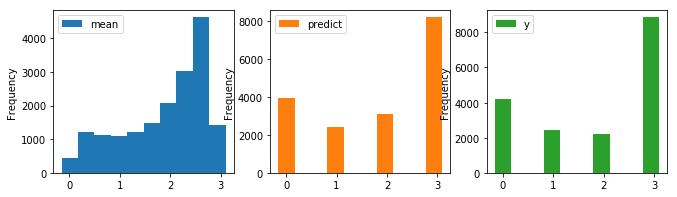

In [43]:
df[['mean','predict','y']].plot(subplots=True,layout=(1, 3),figsize=(11, 3),kind='hist')

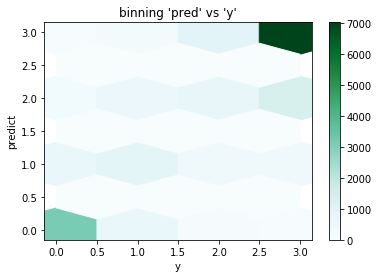

In [44]:
# binning plot of 'pred' versus 'y'
df.plot.hexbin(x='y', y='predict', gridsize=(3,3), sharex=False, title = "binning 'pred' vs 'y'")

## Make submission

In [45]:
preds = []
for model in cat_models:        # CatBoost
    pred = model.predict(X_test)
    preds.append(pred)
for model in xgb_models:        # XGBoost
    pred = model.predict(xgb.DMatrix(X_test))
    pred = pred.flatten()
    preds.append(pred)
for model in lgb_models:        # LightGBM
    pred = model.predict(X_test,num_iteration=model.best_iteration)
    pred = pred.reshape(len(X_test),1).flatten()
    preds.append(pred)
df_s = pd.DataFrame(preds).T

df_s['mean'] = df_s.mean(axis = 'columns')

# Classification
df_s['pred'] = optR.predict(df_s['mean'].values, coefficients).astype(int)

print(df_s.shape)
df_s[['mean','pred']].head(10)

(1000, 17)


,mean,pred
0,2.262456,3
1,2.854861,3
2,2.672723,3
3,2.530354,3
4,2.592157,3
5,2.654960,3
6,2.054199,2
7,2.074660,2
8,0.240176,0
9,1.897099,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f86a4ab1e10>,
      dtype=object)

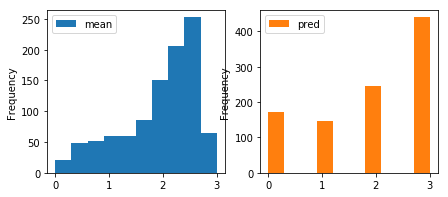

In [46]:
df_s[['mean','pred']].plot(subplots=True, layout=(1, 2), figsize=(7, 3), kind='hist')

In [47]:
submission = pd.read_csv(os.path.join(DIR,'sample_submission.csv'))
submission['accuracy_group'] = df_s['pred']
submission.head(10)

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
5,02256298,3
6,0267757a,2
7,027e7ce5,2
8,02a29f99,0
9,0300c576,2


In [48]:
submission.to_csv('submission.csv', index=None)